<a href="https://colab.research.google.com/github/coyolxahuqui/Tareas-UIC/blob/main/segmentacion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch

input = torch.randn(64, 10, 20, 20)
# aumentamos la dimensión x2
conv_trans = torch.nn.ConvTranspose2d(
    in_channels=10,
    out_channels=20,
    kernel_size=2,
    stride=2)
output = conv_trans(input)
output.shape

torch.Size([64, 20, 40, 40])

In [3]:
pip install wget

  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9656 sha256=7bfa8ea86b50afee84f568d65e696ab1d3236cb7c1e50f781d9150326c96412a
  Stored in directory: /root/.cache/pip/wheels/8b/f1/7f/5c94f0a7a505ca1c81cd1d9208ae2064675d97582078e6c769
Successfully built wget


In [4]:
import wget

url = 'https://mymldatasets.s3.eu-de.cloud-object-storage.appdomain.cloud/MRIs.zip'
wget.download(url)

'MRIs.zip'

In [5]:
import zipfile
with zipfile.ZipFile('MRIs.zip', 'r') as zip_ref:
    zip_ref.extractall('.')

In [6]:
import os
from pathlib import Path

path = Path('./MRIs')
imgs = [path/'MRIs'/i for i in os.listdir(path/'MRIs')]
ixs = [i.split('_')[-1] for i in os.listdir(path/'MRIs')]
masks = [path/'Segmentations'/f'segm_{ix}' for ix in ixs]

len(imgs), len(masks)

(425, 425)

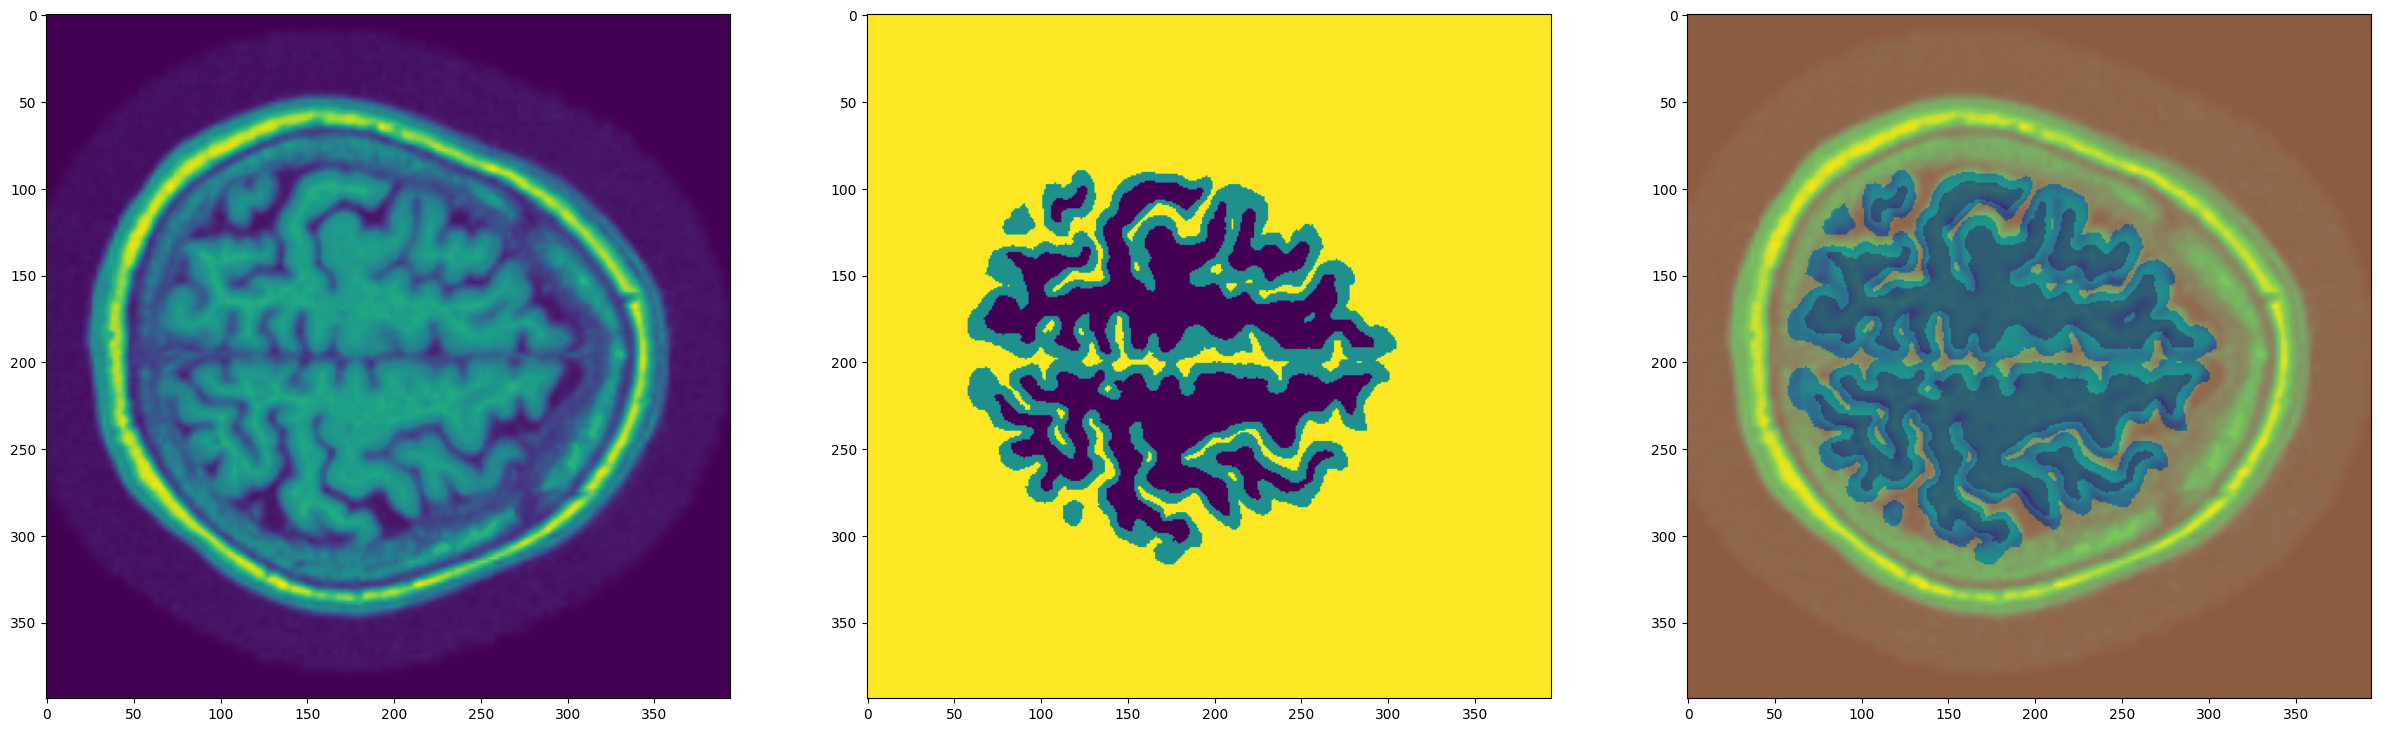

In [7]:
import matplotlib.pyplot as plt
import numpy as np

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30,10))
img = np.load(imgs[0])
mask = np.load(masks[0])
ax1.imshow(img)
ax2.imshow(mask)
ax3.imshow(img)
ax3.imshow(mask, alpha=0.4)
plt.show()

In [8]:
img.shape, img.dtype, img.max(), img.min()

((394, 394), dtype('float32'), 1.0653939, 0.00025629325)

In [9]:
mask.shape, mask.dtype, mask.max(), mask.min()

((394, 394), dtype('uint8'), 2, 0)

In [10]:
# one-hot encoding
mask_oh = (np.arange(3) == mask[...,None]).astype(np.float32)

mask_oh.shape, mask_oh.dtype, mask_oh.max(), mask_oh.min()

((394, 394, 3), dtype('float32'), 1.0, 0.0)

In [11]:
import torch.nn.functional as F

def conv3x3_bn(ci, co):
    return torch.nn.Sequential(
        torch.nn.Conv2d(ci, co, 3, padding=1),
        torch.nn.BatchNorm2d(co),
        torch.nn.ReLU(inplace=True)
    )

def encoder_conv(ci, co):
  return torch.nn.Sequential(
        torch.nn.MaxPool2d(2),
        conv3x3_bn(ci, co),
        conv3x3_bn(co, co),
    )

class deconv(torch.nn.Module):
    def __init__(self, ci, co):
        super(deconv, self).__init__()
        self.upsample = torch.nn.ConvTranspose2d(ci, co, 2, stride=2)
        self.conv1 = conv3x3_bn(ci, co)
        self.conv2 = conv3x3_bn(co, co)

    # recibe la salida de la capa anetrior y la salida de la etapa
    # correspondiente del encoder
    def forward(self, x1, x2):
        x1 = self.upsample(x1)
        diffX = x2.size()[2] - x1.size()[2]
        diffY = x2.size()[3] - x1.size()[3]
        x1 = F.pad(x1, (diffX, 0, diffY, 0))
        # concatenamos los tensores
        x = torch.cat([x2, x1], dim=1)
        x = self.conv1(x)
        x = self.conv2(x)
        return x

class UNet(torch.nn.Module):
    def __init__(self, n_classes=3, in_ch=1):
        super().__init__()

        # lista de capas en encoder-decoder con número de filtros
        c = [16, 32, 64, 128]

        # primera capa conv que recibe la imagen
        self.conv1 = torch.nn.Sequential(
          conv3x3_bn(in_ch, c[0]),
          conv3x3_bn(c[0], c[0]),
        )
        # capas del encoder
        self.conv2 = encoder_conv(c[0], c[1])
        self.conv3 = encoder_conv(c[1], c[2])
        self.conv4 = encoder_conv(c[2], c[3])

        # capas del decoder
        self.deconv1 = deconv(c[3],c[2])
        self.deconv2 = deconv(c[2],c[1])
        self.deconv3 = deconv(c[1],c[0])

        # útlima capa conv que nos da la máscara
        self.out = torch.nn.Conv2d(c[0], n_classes, 3, padding=1)

    def forward(self, x):
        # encoder
        x1 = self.conv1(x)
        x2 = self.conv2(x1)
        x3 = self.conv3(x2)
        x = self.conv4(x3)
        # decoder
        x = self.deconv1(x, x3)
        x = self.deconv2(x, x2)
        x = self.deconv3(x, x1)
        x = self.out(x)
        return x

In [12]:
model = UNet()
output = model(torch.randn((10,1,394,394)))
output.shape

torch.Size([10, 3, 394, 394])

In [13]:
device = "cuda" if torch.cuda.is_available() else "cpu"

def fit(model, X, y, epochs=1, lr=3e-4):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = torch.nn.BCEWithLogitsLoss()
    model.to(device)
    X, y = X.to(device), y.to(device)
    model.train()
    for epoch in range(1, epochs+1):
        optimizer.zero_grad()
        y_hat = model(X)
        loss = criterion(y_hat, y)
        loss.backward()
        optimizer.step()
        print(f"Epoch {epoch}/{epochs} loss {loss.item():.5f}")

In [14]:
img_tensor = torch.tensor(img).unsqueeze(0).unsqueeze(0)
mask_tensor = torch.tensor(mask_oh).permute(2, 0, 1).unsqueeze(0)

img_tensor.shape, mask_tensor.shape

(torch.Size([1, 1, 394, 394]), torch.Size([1, 3, 394, 394]))

In [15]:
fit(model, img_tensor, mask_tensor, epochs=20)

Epoch 1/20 loss 0.72091
Epoch 2/20 loss 0.69815
Epoch 3/20 loss 0.68123
Epoch 4/20 loss 0.66610
Epoch 5/20 loss 0.65300
Epoch 6/20 loss 0.64164
Epoch 7/20 loss 0.63146
Epoch 8/20 loss 0.62184
Epoch 9/20 loss 0.61255
Epoch 10/20 loss 0.60343
Epoch 11/20 loss 0.59433
Epoch 12/20 loss 0.58537
Epoch 13/20 loss 0.57646
Epoch 14/20 loss 0.56745
Epoch 15/20 loss 0.55841
Epoch 16/20 loss 0.54937
Epoch 17/20 loss 0.54031
Epoch 18/20 loss 0.53128
Epoch 19/20 loss 0.52237
Epoch 20/20 loss 0.51364


In [16]:
def iou(outputs, labels):
    # aplicar sigmoid y convertir a binario
    outputs, labels = torch.sigmoid(outputs) > 0.5, labels > 0.5
    SMOOTH = 1e-6
    # BATCH x num_classes x H x W
    B, N, H, W = outputs.shape
    ious = []
    for i in range(N-1): # saltamos el background
        _out, _labs = outputs[:,i,:,:], labels[:,i,:,:]
        intersection = (_out & _labs).float().sum((1, 2))
        union = (_out | _labs).float().sum((1, 2))
        iou = (intersection + SMOOTH) / (union + SMOOTH)
        ious.append(iou.mean().item())
    return np.mean(ious)

In [17]:
def fit(model, X, y, epochs=1, lr=1e-3):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = torch.nn.BCEWithLogitsLoss()
    model.to(device)
    X, y = X.to(device), y.to(device)
    model.train()
    for epoch in range(1, epochs+1):
        optimizer.zero_grad()
        y_hat = model(X)
        loss = criterion(y_hat, y)
        loss.backward()
        optimizer.step()
        ious = iou(y_hat, y)
        print(f"Epoch {epoch}/{epochs} loss {loss.item():.5f} iou {ious:.5f}")

In [18]:
fit(model, img_tensor, mask_tensor, epochs=100)

Epoch 1/100 loss 0.50501 iou 0.42873
Epoch 2/100 loss 0.48269 iou 0.45206
Epoch 3/100 loss 0.45825 iou 0.47109
Epoch 4/100 loss 0.43259 iou 0.53502
Epoch 5/100 loss 0.41016 iou 0.57931
Epoch 6/100 loss 0.39219 iou 0.60171
Epoch 7/100 loss 0.37388 iou 0.60451
Epoch 8/100 loss 0.35664 iou 0.60715
Epoch 9/100 loss 0.34134 iou 0.60540
Epoch 10/100 loss 0.32728 iou 0.59850
Epoch 11/100 loss 0.31382 iou 0.58595
Epoch 12/100 loss 0.30082 iou 0.57287
Epoch 13/100 loss 0.28876 iou 0.55704
Epoch 14/100 loss 0.27776 iou 0.54751
Epoch 15/100 loss 0.26711 iou 0.53809
Epoch 16/100 loss 0.25692 iou 0.53666
Epoch 17/100 loss 0.24752 iou 0.53442
Epoch 18/100 loss 0.23847 iou 0.53079
Epoch 19/100 loss 0.22986 iou 0.52657
Epoch 20/100 loss 0.22158 iou 0.52823
Epoch 21/100 loss 0.21392 iou 0.52904
Epoch 22/100 loss 0.20660 iou 0.53015
Epoch 23/100 loss 0.19931 iou 0.53812
Epoch 24/100 loss 0.19262 iou 0.54542
Epoch 25/100 loss 0.18621 iou 0.56677
Epoch 26/100 loss 0.18183 iou 0.56762
Epoch 27/100 loss 0.1

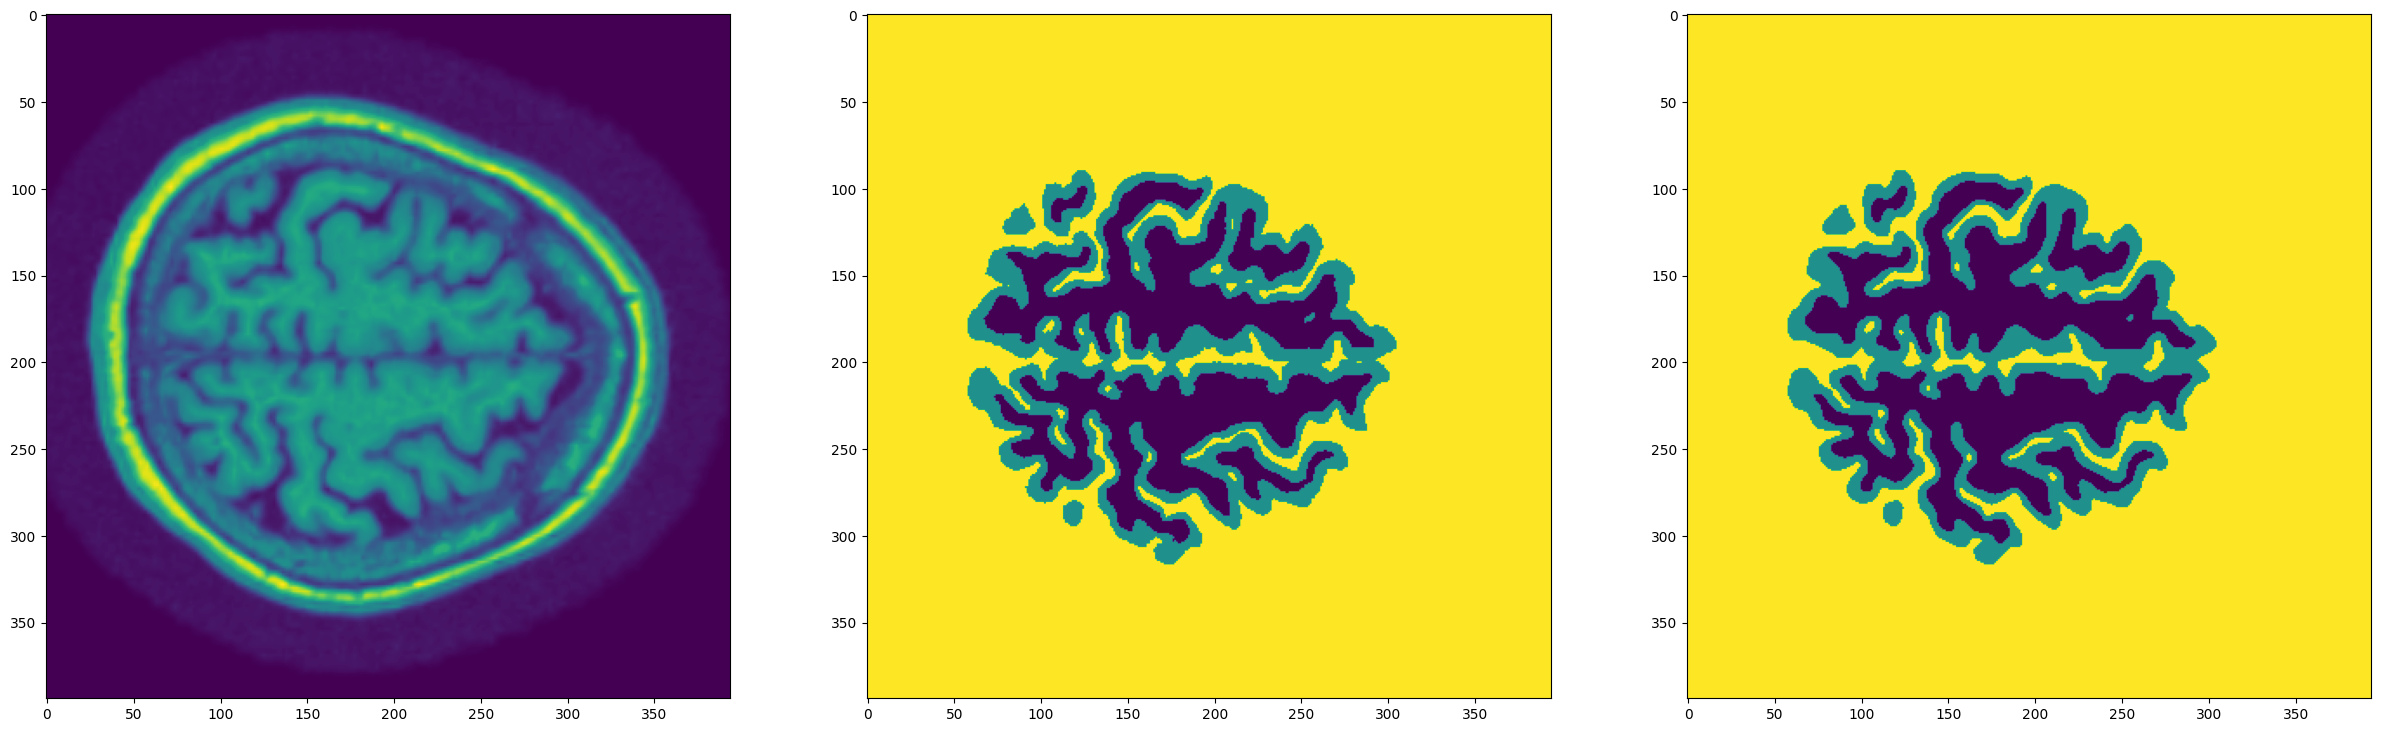

In [19]:
model.eval()
with torch.no_grad():
    output = model(img_tensor.to(device))[0]
    pred_mask = torch.argmax(output, axis=0)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30,10))
ax1.imshow(img)
ax2.imshow(mask)
ax3.imshow(pred_mask.squeeze().cpu().numpy())
plt.show()

In [20]:
#utilizar todo el conjunto de datos
class Dataset(torch.utils.data.Dataset):
  def __init__(self, X, y, n_classes=3):
    self.X = X
    self.y = y
    self.n_classes = n_classes

  def __len__(self):
    return len(self.X)

  def __getitem__(self, ix):
    img = np.load(self.X[ix])
    mask = np.load(self.y[ix])
    img = torch.tensor(img).unsqueeze(0)
    mask = (np.arange(self.n_classes) == mask[...,None]).astype(np.float32)
    return img, torch.from_numpy(mask).permute(2,0,1)

In [21]:
dataset = {
    'train': Dataset(imgs[:-100], masks[:-100]),
    'test': Dataset(imgs[-100:], masks[-100:])
}

len(dataset['train']), len(dataset['test'])

(325, 100)

In [22]:
dataloader = {
    'train': torch.utils.data.DataLoader(dataset['train'], batch_size=16, shuffle=True, pin_memory=True),
    'test': torch.utils.data.DataLoader(dataset['test'], batch_size=32, pin_memory=True)
}

imgs, masks = next(iter(dataloader['train']))
imgs.shape, masks.shape

(torch.Size([16, 1, 394, 394]), torch.Size([16, 3, 394, 394]))

In [23]:
from tqdm import tqdm

def fit(model, dataloader, epochs=100, lr=3e-4):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = torch.nn.BCEWithLogitsLoss()
    model.to(device)
    hist = {'loss': [], 'iou': [], 'test_loss': [], 'test_iou': []}
    for epoch in range(1, epochs+1):
      bar = tqdm(dataloader['train'])
      train_loss, train_iou = [], []
      model.train()
      for imgs, masks in bar:
        imgs, masks = imgs.to(device), masks.to(device)
        optimizer.zero_grad()
        y_hat = model(imgs)
        loss = criterion(y_hat, masks)
        loss.backward()
        optimizer.step()
        ious = iou(y_hat, masks)
        train_loss.append(loss.item())
        train_iou.append(ious)
        bar.set_description(f"loss {np.mean(train_loss):.5f} iou {np.mean(train_iou):.5f}")
      hist['loss'].append(np.mean(train_loss))
      hist['iou'].append(np.mean(train_iou))
      bar = tqdm(dataloader['test'])
      test_loss, test_iou = [], []
      model.eval()
      with torch.no_grad():
        for imgs, masks in bar:
          imgs, masks = imgs.to(device), masks.to(device)
          y_hat = model(imgs)
          loss = criterion(y_hat, masks)
          ious = iou(y_hat, masks)
          test_loss.append(loss.item())
          test_iou.append(ious)
          bar.set_description(f"test_loss {np.mean(test_loss):.5f} test_iou {np.mean(test_iou):.5f}")
      hist['test_loss'].append(np.mean(test_loss))
      hist['test_iou'].append(np.mean(test_iou))
      print(f"\nEpoch {epoch}/{epochs} loss {np.mean(train_loss):.5f} iou {np.mean(train_iou):.5f} test_loss {np.mean(test_loss):.5f} test_iou {np.mean(test_iou):.5f}")
    return hist

In [24]:
model = UNet()
hist = fit(model, dataloader, epochs=30)

test_loss 0.63387 test_iou 0.10161: 100%|██████████| 4/4 [00:01<00:00,  3.26it/s]



Epoch 1/30 loss 0.58865 iou 0.33742 test_loss 0.63387 test_iou 0.10161


test_loss 0.48317 test_iou 0.32751: 100%|██████████| 4/4 [00:01<00:00,  3.39it/s]



Epoch 2/30 loss 0.46265 iou 0.42440 test_loss 0.48317 test_iou 0.32751


test_loss 0.34061 test_iou 0.39029: 100%|██████████| 4/4 [00:01<00:00,  2.84it/s]



Epoch 3/30 loss 0.35549 iou 0.49869 test_loss 0.34061 test_iou 0.39029


test_loss 0.23979 test_iou 0.38413: 100%|██████████| 4/4 [00:01<00:00,  3.46it/s]



Epoch 4/30 loss 0.27229 iou 0.40067 test_loss 0.23979 test_iou 0.38413


test_loss 0.19757 test_iou 0.40039: 100%|██████████| 4/4 [00:01<00:00,  3.41it/s]



Epoch 5/30 loss 0.21708 iou 0.39290 test_loss 0.19757 test_iou 0.40039


test_loss 0.19554 test_iou 0.30167: 100%|██████████| 4/4 [00:01<00:00,  3.46it/s]



Epoch 6/30 loss 0.18151 iou 0.39833 test_loss 0.19554 test_iou 0.30167


test_loss 0.14891 test_iou 0.50464: 100%|██████████| 4/4 [00:01<00:00,  3.38it/s]



Epoch 7/30 loss 0.15729 iou 0.42728 test_loss 0.14891 test_iou 0.50464


test_loss 0.13795 test_iou 0.64436: 100%|██████████| 4/4 [00:01<00:00,  3.41it/s]



Epoch 8/30 loss 0.13656 iou 0.60348 test_loss 0.13795 test_iou 0.64436


test_loss 0.11925 test_iou 0.68239: 100%|██████████| 4/4 [00:01<00:00,  3.43it/s]



Epoch 9/30 loss 0.12221 iou 0.67031 test_loss 0.11925 test_iou 0.68239


test_loss 0.11072 test_iou 0.69412: 100%|██████████| 4/4 [00:01<00:00,  2.81it/s]



Epoch 10/30 loss 0.11202 iou 0.69251 test_loss 0.11072 test_iou 0.69412


test_loss 0.11098 test_iou 0.67275: 100%|██████████| 4/4 [00:01<00:00,  3.33it/s]



Epoch 11/30 loss 0.10288 iou 0.70649 test_loss 0.11098 test_iou 0.67275


test_loss 0.09735 test_iou 0.71908: 100%|██████████| 4/4 [00:01<00:00,  3.53it/s]



Epoch 12/30 loss 0.09682 iou 0.71591 test_loss 0.09735 test_iou 0.71908


test_loss 0.09264 test_iou 0.71945: 100%|██████████| 4/4 [00:01<00:00,  3.41it/s]



Epoch 13/30 loss 0.08973 iou 0.73125 test_loss 0.09264 test_iou 0.71945


test_loss 0.09479 test_iou 0.69019: 100%|██████████| 4/4 [00:01<00:00,  3.42it/s]



Epoch 14/30 loss 0.08520 iou 0.73582 test_loss 0.09479 test_iou 0.69019


test_loss 0.08592 test_iou 0.71983: 100%|██████████| 4/4 [00:01<00:00,  3.44it/s]



Epoch 15/30 loss 0.08169 iou 0.73988 test_loss 0.08592 test_iou 0.71983


test_loss 0.07847 test_iou 0.74934: 100%|██████████| 4/4 [00:01<00:00,  3.41it/s]



Epoch 16/30 loss 0.07792 iou 0.74724 test_loss 0.07847 test_iou 0.74934


test_loss 0.07738 test_iou 0.74211: 100%|██████████| 4/4 [00:01<00:00,  3.13it/s]



Epoch 17/30 loss 0.07475 iou 0.75301 test_loss 0.07738 test_iou 0.74211


test_loss 0.07924 test_iou 0.72932: 100%|██████████| 4/4 [00:01<00:00,  2.79it/s]



Epoch 18/30 loss 0.07255 iou 0.75414 test_loss 0.07924 test_iou 0.72932


test_loss 0.11806 test_iou 0.65119: 100%|██████████| 4/4 [00:01<00:00,  3.39it/s]



Epoch 19/30 loss 0.07309 iou 0.74882 test_loss 0.11806 test_iou 0.65119


test_loss 0.07492 test_iou 0.73951: 100%|██████████| 4/4 [00:01<00:00,  3.48it/s]



Epoch 20/30 loss 0.07064 iou 0.75426 test_loss 0.07492 test_iou 0.73951


test_loss 0.07286 test_iou 0.74533: 100%|██████████| 4/4 [00:01<00:00,  3.36it/s]



Epoch 21/30 loss 0.06722 iou 0.76306 test_loss 0.07286 test_iou 0.74533


test_loss 0.07311 test_iou 0.73850: 100%|██████████| 4/4 [00:01<00:00,  3.38it/s]



Epoch 22/30 loss 0.06559 iou 0.76525 test_loss 0.07311 test_iou 0.73850


test_loss 0.08187 test_iou 0.70251: 100%|██████████| 4/4 [00:01<00:00,  3.45it/s]



Epoch 23/30 loss 0.06414 iou 0.76838 test_loss 0.08187 test_iou 0.70251


test_loss 0.07306 test_iou 0.73215: 100%|██████████| 4/4 [00:01<00:00,  3.37it/s]



Epoch 24/30 loss 0.06113 iou 0.77761 test_loss 0.07306 test_iou 0.73215


test_loss 0.06754 test_iou 0.75687: 100%|██████████| 4/4 [00:01<00:00,  3.15it/s]



Epoch 25/30 loss 0.06028 iou 0.77715 test_loss 0.06754 test_iou 0.75687


test_loss 0.06365 test_iou 0.76856: 100%|██████████| 4/4 [00:01<00:00,  2.79it/s]



Epoch 26/30 loss 0.05848 iou 0.78257 test_loss 0.06365 test_iou 0.76856


test_loss 0.06314 test_iou 0.76796: 100%|██████████| 4/4 [00:01<00:00,  3.37it/s]



Epoch 27/30 loss 0.05713 iou 0.78614 test_loss 0.06314 test_iou 0.76796


test_loss 0.06337 test_iou 0.76627: 100%|██████████| 4/4 [00:01<00:00,  3.38it/s]



Epoch 28/30 loss 0.05646 iou 0.78698 test_loss 0.06337 test_iou 0.76627


test_loss 0.06292 test_iou 0.76444: 100%|██████████| 4/4 [00:01<00:00,  3.34it/s]



Epoch 29/30 loss 0.05444 iou 0.79260 test_loss 0.06292 test_iou 0.76444


test_loss 0.06385 test_iou 0.75430: 100%|██████████| 4/4 [00:01<00:00,  3.49it/s]


Epoch 30/30 loss 0.05334 iou 0.79553 test_loss 0.06385 test_iou 0.75430


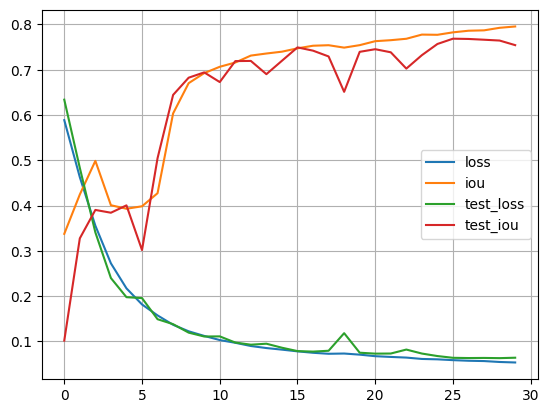

In [25]:
import pandas as pd
df = pd.DataFrame(hist)
df.plot(grid=True)
plt.show()